# Preprocessing workflow

The purpose of this notebook is to show how to write a Nipype workflow to preprocess fMRI data from a single subject or a whole experiment. Nipype provides a common interface structure for various neuroimaging software packages and an intelligent way to handle execution of the various steps in the pipeline.

Utilizing nipype workflows has several advantages, such as utilizing parallel processing, cache-ing, handling inputs and outputs uniformly, and being able to visualize the entire workflow. For a detailed look at Nipype, see [the original article](https://mcgovern.mit.edu/wp-content/uploads/2019/01/fninf-05-00013-1.pdf), and look through [its documentation.](https://nipype.readthedocs.io/en/latest/)

In this workflow, we will be using FSL and ANTS but Nipype is also able to interface SPM, AFNI, FreeSurfer and many more neuroimaging software packages, provided you have them installed in your system. 

## Anatomical preprocessing

Prior to handling the functional data, we will preprocess the anatomical data to prepare for the functional to structural registration (i.e. co-registration) of the multiple BOLD runs for a subject.

Steps we will take are:

1. Bias field correction - ANTs' N4BiasFieldCorrection.
2. Skull-stripping - FSL's Brain Extraction Tool (BET).
3. Spatial normalization - ANTs' Affine and Diffeomorphic (SyN) Registration.

### Workflow and Nodes

Nipype's workflow engine allows concatenating the result of multiple operations and formally specifying the how preprocessing inputs and output should be connected. The individual operations are contained inside *nodes*.These can be the preprocessing algorithm to be be applied to the data or auxiliary interfaces or functions, such as those handling input and output of files.

Let's go ahead and set up the workflow.

In [1]:
from nipype import MapNode, Node, Workflow, Function
import os

# Set up relevant paths
project_dir = os.path.abspath('..')
data_dir = 'data/ds000171/'
preproc_dir = 'src/cache/'
base_dir = os.path.join(project_dir, preproc_dir)

wf = Workflow(name = 'preproc_wf', base_dir = base_dir)

#### Grabbing data

Thanks to PyBIDS, programming data input for neuroimaging pipelines is really easy and legible (provided you have used the BIDS to organize your data directory, of course).

In [2]:
from bids.layout import BIDSLayout

# Initalize layout to data location
layout = BIDSLayout(os.path.join(project_dir, data_dir))

# Produce relevant lists for workflow; limit to 2 subjects and 2 functional runs per subject in notebook
subjects = layout.get_subjects()[:1]
runs = layout.get_runs()[:1]

In [3]:
from nipype.interfaces.io import BIDSDataGrabber

grab_data = Node(BIDSDataGrabber(), name = 'grab_data')
grab_data.inputs.base_dir = os.path.join(project_dir, data_dir)

# Iterate through subjects
grab_data.iterables = ('subject', subjects)

# Define filetypes to grab, and how ouput will be accesses by other nodes 
grab_data.inputs.output_query['T1w'] = dict(extension=['nii.gz'], suffix='T1w')
grab_data.inputs.output_query['bold'] = dict(extension=['nii.gz'], suffix='bold')
#{'T1w': dict(extension=['nii.gz'], suffix='T1w'), 'bold': dict(extension=['nii.gz'], suffix='bold')}

Because the output of `BIDSDataGrabber` is a 1-element list and `DerivativesDataSink` only accepts strings, we need to make use of a simple interface for selecting elements from lists, the `Select` interface.

In [4]:
from nipype.interfaces.utility import Select
sel_anat = Node(Select(index=0), name='sel_anat') # Interface that will select the first element from a list
wf.connect(grab_data, 'T1w', sel_anat, 'inlist')

#### Bias Field Correction

Next, we will correct the intensity inhomogeneities in the T1-weighted images using the `N4BiasFieldCorrection` algorithm from ANTs. 

In [5]:
from nipype.interfaces.ants import N4BiasFieldCorrection

n4_biascorrect = Node(N4BiasFieldCorrection(), name='n4bias_correct')

n4_biascorrect.inputs.save_bias = True
n4_biascorrect.inputs.dimension = 3

Normally we would also specify:
```python
n4_biascorrect.inputs.output_image = 'output/ants-n4/anat_corrected.nii.gz'
n4_biascorrect.inputs.bias_image = 'output/ants-n4/anat_bias.nii.gz'
```

But the workflow engine handles input/output files in relation to preceding/subsequent nodes.

Also, learning the parameters for the [ANTs N4BiasFieldCorrection interface](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.html#n4biasfieldcorrection), or any other interface for that matter, is easy given Nipype's well-kept documentation.

The arguments of `Workflow.connect` can be written as
```python
'node_of_output', 'the_out_file', 'node_of_input', 'the_in_file'
```
or a list of 3-tuples, each specifyng node-to-node relationship where the third element is a list of 2-tuples representing file-to-file relationships
```python
[('node_of_output_1', 'node_of_input_1', [('out_file_1', 'in_file_1'),
                                          ('out_file_2', 'in_file_2')])]
```
Here, we opt for the second way to remain consistent later when we declare multiple connections at once.

In [6]:
wf.connect(sel_anat, 'out', n4_biascorrect, 'input_image')

#### Brain Extraction

For skull-stripping, we will write a sub-workflow that 
1. runs FSL's BET on an image
2. calculates the center of mass for the resulting brain mask
3. re-runs BET on the original image with the center of mass from step 2.

Note that we define this workflow as a function. This will allow us to reuse the workflow without having to rewrite the nodes.

In [7]:
def init_improved_bet(name):
    """Recomputes a brain mask accounting for center of mass"""
    
    from nipype.interfaces.fsl import BET
    from scipy.ndimage.measurements import center_of_mass
    from nipype import Workflow, Node, Function, IdentityInterface 
    import nibabel
    
    improved_bet = Workflow(name = name)
    
    inputnode = Node(IdentityInterface(fields = ['image']), name = 'inputspec')
        
    bet = Node(BET(), name = 'bet_init')
    bet.inputs.frac = 0.5
    bet.inputs.mask = True
    bet.inputs.no_output = True # no output on first pass

    def get_cog(brain_mask):
        import nibabel as nib
        mask = nib.load(brain_mask).get_fdata()

        from scipy.ndimage.measurements import center_of_mass
        cog = [int(x) for x in list(center_of_mass(mask))]
        print("Center"cog)
        return(cog)

    center = Node(Function(function=get_cog, 
                               inputs_names='brain_mask', 
                               output_names='cog'), 
                      name = 'get_center')
    
    bet_cog  = Node(BET(), name='bet_improved')
    bet_cog.inputs.frac = 0.3 # Lenient boundarization 
    bet_cog.inputs.mask = True
    
    outputnode = Node(IdentityInterface(fields = ['brain', 'mask']), name = 'outputspec')
    
    improved_bet.connect([(inputnode, bet, [('image', 'in_file')]),
                          (bet, center, [('mask_file', 'brain_mask')]),
                          (center, bet_cog, [('cog', 'center')]),
                          (inputnode, bet_cog, [('image', 'in_file')]),
                          (bet_cog, outputnode, [('out_file', 'brain'),
                                                 ('mask_file', 'mask')])])
    return improved_bet

Now, we initialize one instance of this workflow for our anatomic preprocessing pipeline.

In [8]:
bet_anat_wf = init_improved_bet(name = "bet_anat_wf")

And we pass the N4 bias-corrected image directly onto the input node in this workflow. 

In [9]:
wf.connect([(n4_biascorrect, bet_anat_wf, [('output_image', 'inputspec.image')])])

Notice that when connecting nodes from a different workflow the following the syntax is a follows:

```python
[('node_of_output', 'workflow_of_input', [('out_file', 'node_name_in_workflow.in_file')])]
```

#### Spatial Normalization

We will register the bias-corrected, skull-stripped anatomical image to the MNI template using ANT's `Registration`. Let's go ahead and declare this node as a function since we will be re-using it for functional preprocessing.

Note: The parameters used in these example result in a quick (~5 mins) registration run time; these parameters are the default in John Muschelli's `extrants` R package. I have tried to add comments throughout based on my understanding from consulting the [ANTs documentation](https://github.com/ANTsX/ANTs/wiki/Anatomy-of-an-antsRegistration-call).

In [10]:
def init_registration_node(name, dim=3):
    """Wraps an antsRegistration node to reuse same parameters"""
    from nipype.interfaces.ants import Registration
    from nipype import Node

    reg = Node(Registration(), name = name)
    
    # Choose the type of transforms, metrics and other general parameters
    reg.inputs.transforms = ['Affine', 'SyN']
    reg.inputs.write_composite_transform = True # join both Affine and Syn transforms into one
    reg.inputs.metric = ['Mattes', 'Mattes'] # Mutual Information metric
    reg.inputs.metric_weight = [1]*2
    reg.inputs.radius_or_number_of_bins = [32]*2 # bins for joint histograms
    reg.inputs.sampling_strategy = ['Regular', None]
    reg.inputs.sampling_percentage = [0.2, 1]
    reg.inputs.winsorize_lower_quantile = 0.005
    reg.inputs.winsorize_upper_quantile = 0.995

    # Parameters are (GradientStep, updateFieldVarianceInVoxelSpace, totalFieldVarianceInVoxelSpace)
    reg.inputs.transform_parameters = [(0.25,), (0.2, 3.0, 0.0)]

    # Implementing multiscale optimization: choose shrinking factors and kernel size per iteration 
    reg.inputs.number_of_iterations = [[2100,1200,1200,0],[40,20,0]]
    reg.inputs.smoothing_sigmas = [[3,2,1,0],[2,1,0]]       
    reg.inputs.shrink_factors = [[4, 2, 2, 1],[4, 2, 1]]

    # Other parameters
    reg.inputs.float = False
    reg.inputs.dimension = dim
    
    return reg

The MNI template that is included with FSL can be accessed via nipype as well.

In [11]:
from nipype.interfaces.fsl import Info
template_path = Info.standard_image('MNI152_T1_1mm_brain.nii.gz')

Now, we initialize the node. And because we want to normalize the anatomical image, we set the `ref_image` to the MNI template. 

In [12]:
reg_anat2template = init_registration_node(name = "reg_anat2template", dim = 3)
reg_anat2template.inputs.fixed_image = template_path

wf.connect([(bet_anat_wf, reg_anat2template, [('outputspec.brain', 'moving_image')])])

Lastly, because of antsRegistration returns only a transformation matrix and not the image, we will need an `ApplyTransforms` node to produce the normalized anatomical image. 

In [13]:
from nipype.interfaces.ants import ApplyTransforms

transf_anat = Node(ApplyTransforms(), name = 'transform_anat')
transf_anat.inputs.reference_image = template_path
transf_anat.inputs.dimension = 3
transf_anat.inputs.interpolation = 'LanczosWindowedSinc'

wf.connect([(reg_anat2template, transf_anat, [('composite_transform',  'transforms')]),
            (bet_anat_wf, transf_anat, [('outputspec.brain', 'input_image')])])

#### Saving output in BIDS Format

The Brain Imaging Data Structure (BIDS) provides a standard to structure neuroimaging datasets that is used across a wide set of applications. Therefore, it would be best to save results of the pipeline in this format in case any of these applications will be used as a later step. At any rate, structuring your data makes it more accessible as show in the [(PyBIDS Notebook)](../data/PyBIDS.ipynb)

In [14]:
from niworkflows.interfaces.bids import DerivativesDataSink

anat_sink = Node(DerivativesDataSink(), name='anat_sink')
anat_sink.inputs.base_directory = os.path.join(project_dir, data_dir)
anat_sink.inputs.desc = 'preproc'

wf.connect([(transf_anat, anat_sink, [('output_image', 'in_file')]),
            (sel_anat, anat_sink, [('out', 'source_file')])])

#### Graph Visualization

Now that we have the anatomical preprocessing part of the workflow, let's visualize it. Since we are using nipype, we can visualize the dataflow between our interfaces easily.

200902-09:39:22,497 nipype.workflow INFO:
	 Generated workflow graph: /Users/vgonzenb/Python/nipy/fmri-rep/src/cache/preproc_wf/anat_workflow_detailed.png (graph2use=exec, simple_form=False).


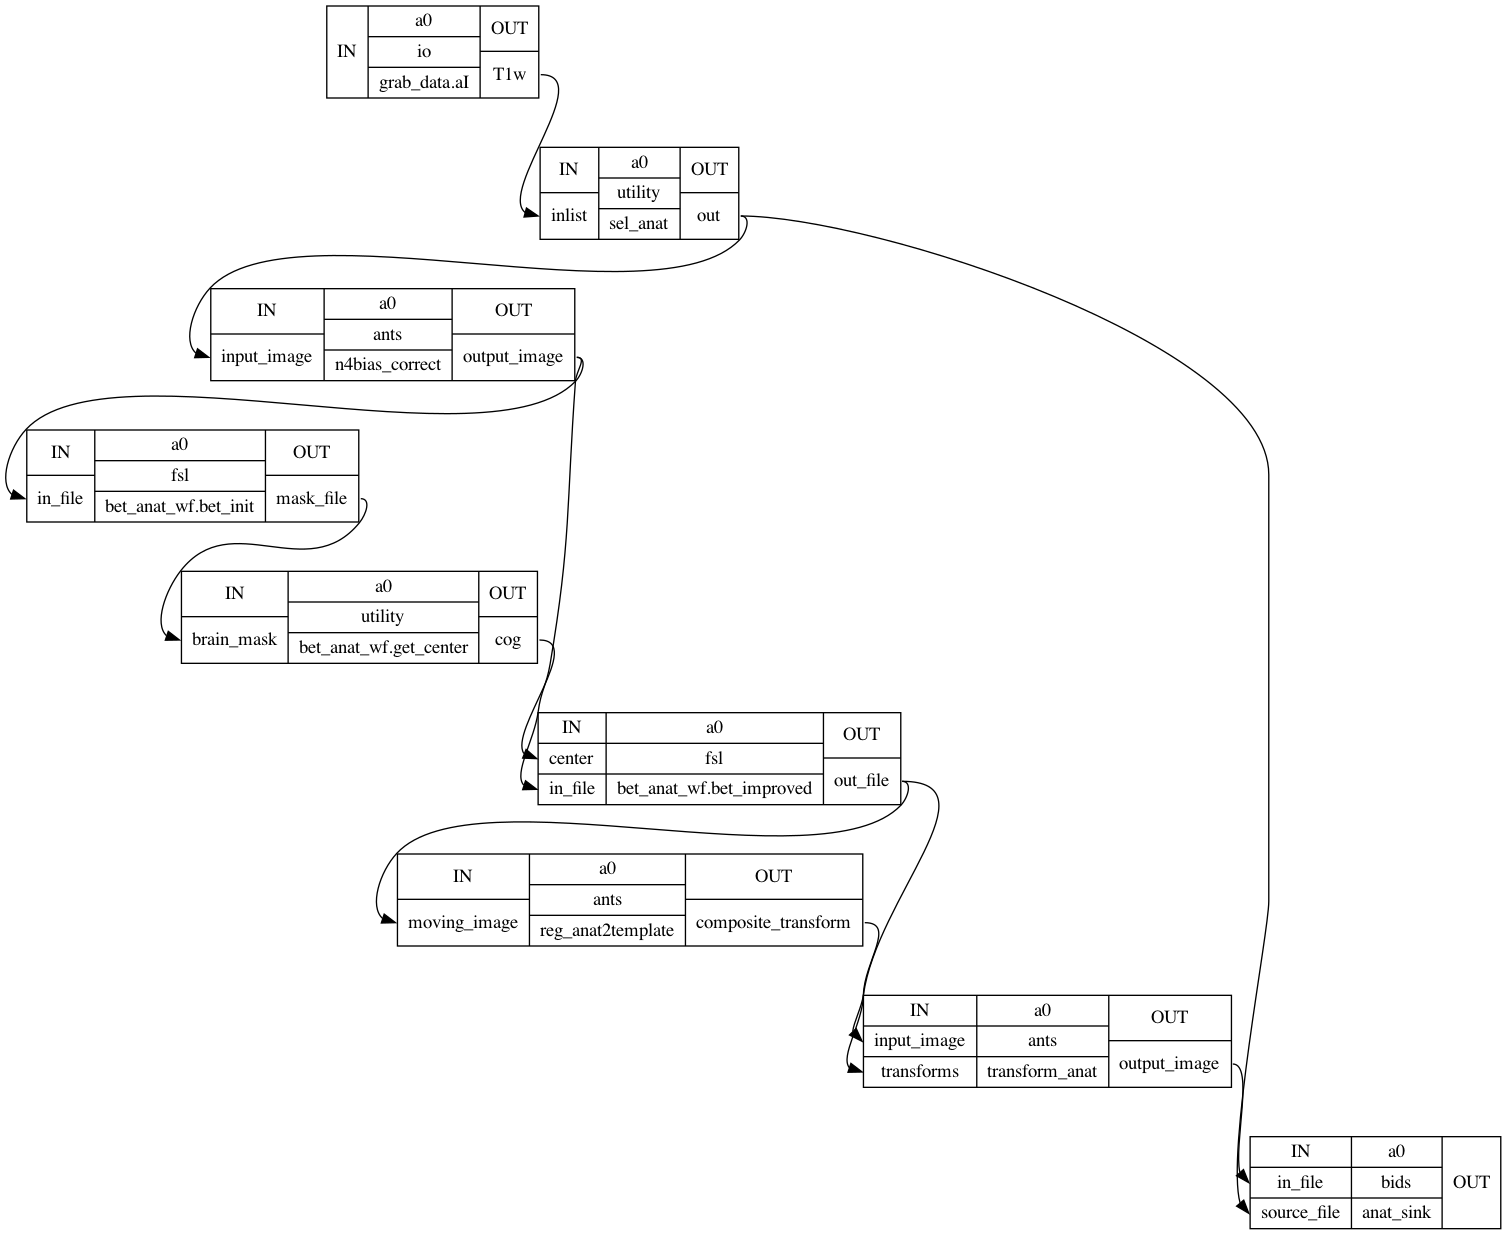

In [15]:
wf.write_graph(dotfilename = 'anat_workflow.dot', graph2use = 'exec', simple_form = False)

# Visualize graph
from IPython.display import Image
Image(filename=os.path.join(base_dir, "preproc_wf/anat_workflow_detailed.png"))

## Functional preprocessing

Now that we tackled anatomical preprocessing, we can start to build the part of the workflow that will handle the BOLD runs. To be clear, when running, the workflow does not have wait for all the anatomical preprocessing steps to be completed before starting to operate on the functional images. In this notebook, these two parts of the workflow are presented separately only for conceptual clarity.

The preprocessing steps and tools we will use are the following:

1. Slice timing correction - FSL's SliceTimer
2. Motion Correction - FSL's MCFLIRT
3. Calculate a brain mask - FSL's BET subworkflow
4. Coregistration to anatomical space - ANTs Registration
5. Spatial normalization - ANT's ApplyTransform function 

### Iterate through runs

#### MapNode

### Grab data

We need to write a select the functional image to work on from the list supplied by BIDSDataGrabber. The `sel_func` below will iterate over the runs so that the preproc workflow we are about to write is executed for each functional image.

In [16]:
sel_func = Node(Select(), name='sel_func') 
sel_func.iterables = ('index', [run - 1 for run in runs])

wf.connect(grab_data, 'bold', sel_func, 'inlist')

### Slice Timing Correction

Because TR = 3s slice timing correction is performed first.

In [17]:
from nipype.interfaces.fsl import SliceTimer

slice_t = Node(SliceTimer(), name = 'slice_timer') 
slice_t.inputs.interleaved = True
slice_t.inputs.time_repetition = 3

#wf.connect(sel_func, 'out', slice_t, 'in_file')
wf.connect(sel_func, 'out', slice_t, 'in_file')

### Motion Correction

In [18]:
from nipype.interfaces.fsl import MCFLIRT

m_corr = Node(MCFLIRT(), name = 'm_corr')

m_corr.inputs.cost = 'mutualinfo'
m_corr.inputs.interpolation = 'sinc'
m_corr.inputs.mean_vol = True # output a mean of time series
m_corr.inputs.save_mats = True
m_corr.inputs.save_plots = True

wf.connect(slice_t, 'slice_time_corrected_file', m_corr, 'in_file')

### Brain Extraction

To create a brain mask for the functional runs we can re-use our improved BET workflow from earlier. Another reason why Nipype is great! Over time we can define multiple small workflows that others can mix and match with relative simplicity.

In [20]:
bet_func_wf = init_improved_bet(name = "bet_func_wf")

wf.connect(m_corr, 'mean_img', bet_func_wf, 'inputspec.image')

### Apply Mask

In [21]:
from nipype.interfaces.fsl import ApplyMask

mask_func = Node(ApplyMask(), name='mask_func')

wf.connect([(bet_func_wf, mask_func, [('outputspec.mask', 'mask_file')]),
            (m_corr, mask_func, [('out_file', 'in_file')])])

### From coregistration to normalization

In this step, we'll register the BOLD runs to normalized anatomical image. First, we need to compute a mean image of the bold run to use in the registration step.

In [22]:
# Compute the mean image
from nipype.interfaces.fsl import MeanImage

mean_img = Node(MeanImage(), name='mean_img')

wf.connect(mask_func, 'out_file', mean_img , 'in_file')

Then we can reuse the `init_registration_node` function to create a 2nd registration node with the same parameters as the first.

In [23]:
reg_func2norm_anat = init_registration_node(name = "reg_func2norm_anat")

wf.connect([(mean_img, reg_func2norm_anat, [('out_file', 'moving_image')]),
            (transf_anat, reg_func2norm_anat, [('output_image', 'fixed_image')])])

Finally, we specify an `ApplyTransform` node to apply the registration.

In [24]:
transf_func = Node(ApplyTransforms(), name = 'transform_func')
transf_func.inputs.dimension = 3
transf_func.inputs.interpolation = 'LanczosWindowedSinc'

wf.connect([(reg_func2norm_anat, transf_func, [('composite_transform',  'transforms')]),
            (mask_func, transf_func, [('out_file', 'input_image')]),
            (transf_anat, transf_func, [('output_image', 'reference_image')])])

In [ ]:
func_sink = Node(DerivativesDataSink(), name='func_sink')
func_sink.inputs.base_directory = os.getcwd()
func_sink.inputs.desc = 'preproc'

wf.connect([(transf_func, func_sink, [('output_image', 'in_file')]),
            (sel_func, func_sink, [('out', 'source_file')])])

### Visualizing the final graph


In [ ]:
wf.write_graph(dotfilename = 'func_workflow.dot', graph2use = 'exec', simple_form = False)

# Visualize graph
from IPython.display import Image
Image(filename=os.path.join(base_dir, "preproc_wf/func_workflow_detailed.png"))

## Executing the workflow

To execute the workflow

```python
wf.run()
```

### Execution Plug-ins

To capitalize on computational resources that you may have at your disposal, execution plug-ins can be specified when making calling `Workflow.run()`. In particular, the MultiProc plug-in is relatively easy to implement.

```python
wf.run(plugin='MultiProc', plugin_args = {'n_procs': 1, 'memory_gb': 4})
````
    n_procs: Number of processes to launch in parallel, if not set number of processors/threads will be automatically detected

    memory_gb: Total memory available to be shared by all simultaneous tasks currently running, if not set it will be automatically set to 90% of system RAM.

    raise_insufficient: Raise exception when the estimated resources of a node exceed the total amount of resources available (memory and threads), when False (default), only a warning will be issued.

    maxtasksperchild: number of nodes to run on each process before refreshing the worker (default: 10).

### Debugging mode

Another useful feature of Nipype is the debugging mode.
```
from nipype import config
config.enable_debug_mode()
```